In [1]:
import pandas as pd
import numpy as np
from freesurfer_stats import CorticalParcellationStats
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
## Tabular Data
project_dir = "../"
metadata_dir = f"{project_dir}/metadata/"
data_dir = "/home/nikhil/projects/brain_changes/data/"

freesurfer_fields = f"{metadata_dir}brainage_fs_ukbb_field_ids.csv"

# ukbb
ukbb_demograph_csv = f"{data_dir}ukbb/tabular/tab_follow_up.csv"
ukbb_FS_csv = f"{data_dir}ukbb/imaging/freesurfer/ukb47552_followup_subset.csv"

# adni
adni_demograph_csv = f"{data_dir}adni/metadata/ADNIMERGE.csv"
adni_FS_DKT_csv = f"{data_dir}adni/imaging/freesurfer/adni_followup_subset_DKT.csv"
adni_FS_aseg_csv = f"{data_dir}adni/imaging/freesurfer/adni_followup_subset_aseg.csv"


## Configs

In [3]:
FS_measures = "DKT" # "DKT", "aseg", or "both"

## Grab Freesurfer measures

In [4]:
freesurfer_fields_df = pd.read_csv(freesurfer_fields)

CT_fields = freesurfer_fields_df[freesurfer_fields_df["stat"]=="DKT"]["Field ID"]
volume_fields = freesurfer_fields_df[freesurfer_fields_df["stat"]=="aseg"]["Field ID"]

print(f"number of CT fields: {len(CT_fields)}, volume fields: {len(volume_fields)}")

if FS_measures == "DKT":
    pheno_fields = CT_fields
elif FS_measures == "aseg":
    pheno_fields = volume_fields
else:
    pheno_fields = CT_fields.append(volume_fields)

pheno_cols_ses2 = list(pheno_fields.astype(str) + "-2.0")
pheno_cols_ses3 = list(pheno_fields.astype(str) + "-3.0")
usecols = ["eid"] + pheno_cols_ses2 + pheno_cols_ses3

print(f"Using {FS_measures} features with 2 timepoints i.e. {len(usecols)} columns")

number of CT fields: 62, volume fields: 36
Using DKT features with 2 timepoints i.e. 125 columns


### UKBB demograph data

In [5]:
tab_data_df = pd.read_csv(ukbb_demograph_csv)
tab_data_df.head()

,eid,sex,birth_year,imaging date-ses2,imaging date-ses3,T1-ses2,T1-ses3,ethnicity,age_at_ses2,age_at_ses3,age_at_recruitment
0,1000635,1.0,1950.0,2017-12-21,2020-03-09,20252_2_0,20252_3_0,1001.0,67.0,69.0,58.0
1,1004084,1.0,1947.0,2017-05-23,2019-10-23,20252_2_0,20252_3_0,1001.0,70.0,72.0,60.0
2,1008391,1.0,1955.0,2017-10-13,2021-02-17,20252_2_0,20252_3_0,1001.0,62.0,65.0,54.0
3,1010063,0.0,1964.0,2017-07-05,2019-10-29,20252_2_0,20252_3_0,1001.0,53.0,55.0,45.0
4,1010129,0.0,1947.0,2017-08-16,2019-11-17,20252_2_0,20252_3_0,1001.0,69.0,71.0,60.0


### UKBB Freesurfer data

In [6]:
print(f"reading {len(usecols)} columes")
ukbb_freesurfer_df = pd.read_csv(ukbb_FS_csv, usecols=usecols)

# Remove eids with missing 2nd or 3rd ses data
eid_missing_data = ukbb_freesurfer_df[ukbb_freesurfer_df.isna().any(axis=1)]["eid"].values
print(f"number participants missing 2nd or 3rd ses freesurfer data: {len(eid_missing_data)}")

ukbb_freesurfer_df = ukbb_freesurfer_df[~ukbb_freesurfer_df["eid"].isin(eid_missing_data)]
freesurfer_eids = ukbb_freesurfer_df["eid"].values

print(f"available freesurfer subjects: {len(freesurfer_eids)}")
ukbb_freesurfer_df = ukbb_freesurfer_df.rename(columns={"eid":"subject_id"})
ukbb_freesurfer_df = ukbb_freesurfer_df.set_index("subject_id")

# Split visits
BL_ukbb_freesurfer_df = ukbb_freesurfer_df[pheno_cols_ses2]
BL_ukbb_freesurfer_df = BL_ukbb_freesurfer_df.rename(columns=dict(zip(pheno_cols_ses2, pheno_fields)))
FU_ukbb_freesurfer_df = ukbb_freesurfer_df[pheno_cols_ses3]
FU_ukbb_freesurfer_df = FU_ukbb_freesurfer_df.rename(columns=dict(zip(pheno_cols_ses3, pheno_fields)))

print(f"BL shape: {BL_ukbb_freesurfer_df.shape}, FU shape: {FU_ukbb_freesurfer_df.shape}")

ukbb_freesurfer_df.head()

reading 125 columes
number participants missing 2nd or 3rd ses freesurfer data: 63
available freesurfer subjects: 3237
BL shape: (3237, 62), FU shape: (3237, 62)


,27174-2.0,27174-3.0,27175-2.0,27175-3.0,27176-2.0,27176-3.0,27177-2.0,27177-3.0,27178-2.0,27178-3.0,...,27293-2.0,27293-3.0,27294-2.0,27294-3.0,27295-2.0,27295-3.0,27296-2.0,27296-3.0,27297-2.0,27297-3.0
subject_id,,,,,,,,,,,,,,,,,,,,,
1000635,2.786,2.874,2.910,2.852,2.275,2.307,3.389,3.379,2.836,2.815,...,2.387,2.435,2.967,2.958,2.707,2.628,2.229,2.142,2.875,2.750
1008391,3.191,2.875,3.080,3.037,2.273,2.143,3.004,2.571,2.846,2.753,...,2.588,2.592,3.073,2.859,2.839,2.770,3.086,3.322,3.255,3.003
1010129,2.329,1.870,2.836,2.798,1.995,1.943,3.302,3.193,2.812,2.801,...,2.376,2.395,3.081,3.086,2.993,2.945,3.016,3.032,3.193,3.168
1010994,2.785,2.581,2.671,2.603,2.060,1.819,3.144,3.225,2.793,2.678,...,2.513,2.416,2.919,2.881,2.654,2.581,2.088,2.161,2.912,2.866
1013774,2.963,3.191,2.617,2.856,2.035,2.050,2.751,3.385,2.830,2.949,...,2.274,2.403,3.041,3.008,2.635,2.737,2.527,2.696,2.983,3.263


### ADNI metadata

In [7]:
adnimerge_df = pd.read_csv(adni_demograph_csv)
print(f"ADNIMERGE len: {len(adnimerge_df)}")

adnimerge_df["subject_id"] = "sub-ADNI" + adnimerge_df["PTID"]
adnimerge_df["subject_id"] = adnimerge_df["subject_id"].str.replace("_","")

useful_cols = ["subject_id","DX_bl","AGE","PTGENDER","VISCODE"]
adnimerge_dx_df = adnimerge_df[(adnimerge_df["VISCODE"]=="bl")][useful_cols]

print(f"adnimerge with longitudinal subjects. n_subjects = {len(adnimerge_dx_df)}")
adnimerge_dx_df.head()

ADNIMERGE len: 11483
adnimerge with longitudinal subjects. n_subjects = 1735


,subject_id,DX_bl,AGE,PTGENDER,VISCODE
0,sub-ADNI011S0002,CN,74.3,Male,bl
1,sub-ADNI011S0003,AD,81.3,Male,bl
5,sub-ADNI022S0004,LMCI,67.5,Male,bl
10,sub-ADNI011S0005,CN,73.7,Male,bl
15,sub-ADNI100S0006,LMCI,80.4,Female,bl


### ADNI Freesurfer data

In [8]:
if FS_measures == "DKT":
    adni_freesurfer_df = pd.read_csv(adni_FS_DKT_csv).set_index("subject_id")
elif FS_measures == "aseg":
    adni_freesurfer_df = pd.read_csv(adni_FS_aseg_csv).set_index("subject_id")
else:
    df1 = pd.read_csv(adni_FS_DKT_csv).set_index("subject_id")
    df2 = pd.read_csv(adni_FS_aseg_csv).set_index("subject_id")

    adni_freesurfer_df = pd.concat([df1,df2],axis=1)

adni_subjects = adni_freesurfer_df.index
print(f"Number of ADNI subjects: {len(adni_subjects)}")

# Split visits
BL_adni_freesurfer_df = adni_freesurfer_df[pheno_cols_ses2]
BL_adni_freesurfer_df = BL_adni_freesurfer_df.rename(columns=dict(zip(pheno_cols_ses2, pheno_fields)))
FU_adni_freesurfer_df = adni_freesurfer_df[pheno_cols_ses3]
FU_adni_freesurfer_df = FU_adni_freesurfer_df.rename(columns=dict(zip(pheno_cols_ses3, pheno_fields)))

print(f"BL shape: {BL_adni_freesurfer_df.shape}, FU shape: {FU_adni_freesurfer_df.shape}")


adni_freesurfer_df.head()

Number of ADNI subjects: 102
BL shape: (102, 62), FU shape: (102, 62)


,27174-2.0,27175-2.0,27176-2.0,27177-2.0,27178-2.0,27179-2.0,27180-2.0,27181-2.0,27182-2.0,27183-2.0,...,27288-3.0,27289-3.0,27290-3.0,27291-3.0,27292-3.0,27293-3.0,27294-3.0,27295-3.0,27296-3.0,27297-3.0
subject_id,,,,,,,,,,,,,,,,,,,,,
sub-ADNI130S4417,2.697,2.474,1.992,3.355,2.792,2.588,3.018,2.592,2.203,2.686,...,2.438,2.462,2.744,2.269,2.623,2.221,2.794,2.344,2.254,2.914
sub-ADNI082S4208,2.528,2.437,1.962,3.507,2.564,2.318,2.575,2.187,2.149,2.379,...,2.413,2.312,2.485,2.285,2.416,2.004,2.676,2.377,2.393,2.890
sub-ADNI031S4032,2.883,2.363,1.768,3.423,2.513,2.363,2.742,2.603,1.995,2.654,...,2.488,2.270,2.855,2.331,2.418,2.034,2.788,2.408,2.719,2.750
sub-ADNI072S4539,2.542,2.483,2.178,3.318,2.624,2.434,2.699,2.376,2.156,2.451,...,2.569,2.395,2.751,2.151,2.452,2.248,2.710,2.460,2.271,2.735
sub-ADNI022S4320,2.648,2.605,1.954,3.411,2.577,2.345,2.732,2.165,2.240,2.672,...,2.379,2.260,2.544,2.416,2.561,2.127,2.686,2.433,2.454,2.984


### Subject specific changes: avg visit differences

In [9]:
ukbb_CT_diff_df = BL_ukbb_freesurfer_df - FU_ukbb_freesurfer_df
adni_CT_diff_df = BL_adni_freesurfer_df - FU_adni_freesurfer_df

ukbb_CT_avg_diff_df = ukbb_CT_diff_df.mean(axis=1).copy().reset_index()
adni_CT_avg_diff_df = adni_CT_diff_df.mean(axis=1).copy().reset_index()

In [10]:
ukbb_CT_avg_diff_df["cohort"] = "ukbb"
ukbb_CT_avg_diff_df["DX_bl"] = "ukbb-CN"

adnimerge_dx_df = adnimerge_dx_df[(adnimerge_dx_df["subject_id"].isin(adni_subjects))]
adni_CT_avg_diff_df["cohort"] = "adni"
adni_CT_avg_diff_df = pd.merge(adni_CT_avg_diff_df, adnimerge_dx_df[["subject_id","DX_bl"]], on="subject_id")
adni_CT_avg_diff_df = adni_CT_avg_diff_df.set_index("subject_id")

ukbb_adni_CT_avg_diff_df = pd.concat([ukbb_CT_avg_diff_df,adni_CT_avg_diff_df],axis=0)
ukbb_adni_CT_avg_diff_df = ukbb_adni_CT_avg_diff_df.rename(columns={0:"avg_change_in_CT"})

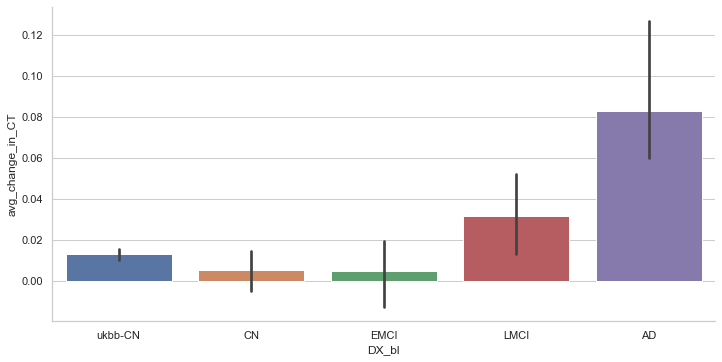

In [11]:
plot_df = ukbb_adni_CT_avg_diff_df.copy()
x_order = ["ukbb-CN","CN","EMCI","LMCI","AD"]
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="DX_bl",y="avg_change_in_CT",order=x_order,kind="bar",aspect=2,data=plot_df)

### Correlation between visits

In [12]:
adni_corr_df = BL_adni_freesurfer_df.corrwith(FU_adni_freesurfer_df,axis=1).reset_index()
ukbb_corr_df = BL_ukbb_freesurfer_df.corrwith(FU_ukbb_freesurfer_df,axis=1).reset_index()

ukbb_corr_df["cohort"] = "ukbb"
ukbb_corr_df["DX_bl"] = "ukbb-CN"

adni_corr_df["cohort"] = "adni"
adni_corr_df = pd.merge(adni_corr_df, adnimerge_dx_df[["subject_id","DX_bl"]], on="subject_id")
adni_corr_df = adni_corr_df.set_index("subject_id")

ukbb_adni_corr_df = pd.concat([ukbb_corr_df,adni_corr_df],axis=0)
ukbb_adni_corr_df = ukbb_adni_corr_df.rename(columns={0:"visit-corr"})

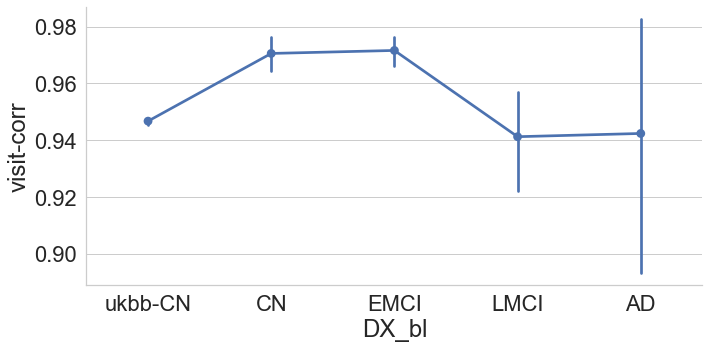

In [22]:
plot_df = ukbb_adni_corr_df.copy()
hue_order = ["ukbb-CN","CN","EMCI","LMCI","AD"]

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="visit-corr",x="DX_bl", kind="point", order=hue_order, aspect=2, data=plot_df)
    

### ROI-wise difference

In [25]:
ukbb_adni_CT_diff_df

,27174,27175,27176,27177,27178,27179,27180,27204,27181,27182,...,27289,27290,27291,27292,27293,27294,27295,27296,cohort,DX_bl
subject_id,,,,,,,,,,,,,,,,,,,,,
1000635,-0.088,0.058,-0.032,0.010,0.021,-0.031,0.062,-0.111,-0.063,-0.051,...,0.004,-0.402,0.022,-0.054,-0.048,0.009,0.079,0.087,ukbb,ukbb-CN
1008391,0.316,0.043,0.130,0.433,0.093,0.026,0.122,0.105,0.179,0.100,...,0.131,0.072,0.081,0.085,-0.004,0.214,0.069,-0.236,ukbb,ukbb-CN
1010129,0.459,0.038,0.052,0.109,0.011,0.096,0.062,0.085,-0.075,-0.005,...,0.019,-0.118,-0.011,-0.101,-0.019,-0.005,0.048,-0.016,ukbb,ukbb-CN
1010994,0.204,0.068,0.241,-0.081,0.115,0.069,0.187,0.167,0.227,0.266,...,0.011,0.106,0.037,0.088,0.097,0.038,0.073,-0.073,ukbb,ukbb-CN
1013774,-0.228,-0.239,-0.015,-0.634,-0.119,-0.158,-0.076,-0.122,0.103,-0.118,...,0.024,0.110,0.156,0.013,-0.129,0.033,-0.102,-0.169,ukbb,ukbb-CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-ADNI137S4672,0.074,0.128,0.091,0.117,0.164,0.048,0.127,0.015,0.107,0.053,...,0.132,-0.107,0.054,0.092,0.139,0.012,0.077,-0.013,adni,AD
sub-ADNI018S4399,0.256,0.078,0.067,0.441,0.128,0.008,-0.035,0.051,-0.058,0.026,...,0.069,-0.121,0.014,0.087,0.026,0.184,0.091,0.150,adni,CN
sub-ADNI053S4813,0.116,0.094,0.023,-0.085,0.038,0.093,-0.005,0.064,0.046,0.040,...,0.073,0.024,0.092,0.107,0.068,0.010,0.036,0.188,adni,EMCI


In [26]:
ukbb_CT_diff_df["cohort"] = "ukbb"
ukbb_CT_diff_df["DX_bl"] = "ukbb-CN"

adni_CT_diff_df["cohort"] = "adni"
adni_CT_diff_df = pd.merge(adni_CT_diff_df, adnimerge_dx_df[["subject_id","DX_bl"]], on="subject_id")
adni_CT_diff_df = adni_CT_diff_df.set_index("subject_id")

ukbb_adni_CT_diff_df = pd.concat([ukbb_CT_diff_df,adni_CT_diff_df],axis=0).reset_index()

ukbb_adni_CT_diff_df_melt = ukbb_adni_CT_diff_df.melt(
    id_vars=["subject_id","DX_bl","cohort"],
    var_name="ROI", 
    value_name="CT",
)
ukbb_adni_CT_diff_df_melt.head()

,subject_id,DX_bl,cohort,ROI,CT
0,1000635,ukbb-CN,ukbb,27174,-0.088
1,1008391,ukbb-CN,ukbb,27174,0.316
2,1010129,ukbb-CN,ukbb,27174,0.459
3,1010994,ukbb-CN,ukbb,27174,0.204
4,1013774,ukbb-CN,ukbb,27174,-0.228


In [ ]:
plot_df = ukbb_adni_CT_diff_df_melt.copy()
hue_order = ["CN","EMCI","LMCI","AD"]
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="ROI",y="CT",kind="point",hue="DX_bl",hue_order=hue_order, aspect=4,data=plot_df)